In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

## NPHET IEMAG 2021-08-11 Model Scenario Projections vs Reported Data (*WORK IN PROGRESS*)

This notebook compares the NPHET IEMAG 2021-08-11 model scenario projections with reported data, for 2021-08-11 to 2021-10-25. The projections are estimated reproductions of those from Figure 1 in the [2021-08-25 NPHET letter to the Minister for Health](https://assets.gov.ie/197023/331de194-9bff-44cf-a633-e4f21e3838c6.pdf).


In [3]:
@dataclass
class ScenarioCurve:
    name: str
    fit_dates: pd.DatetimeIndex
    fit_cases: np.array
        
@dataclass(frozen=True)
class Scenario:
    name: str
    cases: np.array
    mean_cases: int
    hospital_cases: np.array
    mean_hospital_cases: int
    icu_cases: np.array
    mean_icu_cases: int
    #mean_deaths: int
    dates: pd.DatetimeIndex
    color: int

### Scenario data 2021-08-11 to 2021-10-25, based on Figure 1 above

In [4]:
scenario_dates = pd.date_range('2021-08-11', '2021-10-25')

def daily_fit(fit_dates, fit_cases):
    fit_dates = [datetime.strptime(x, '%Y%m%d') for x in fit_dates]
    days = [((x - fit_dates[0]).days) for x in fit_dates]
    pf = np.poly1d(np.polyfit(days, fit_cases, deg=3))
    daily_cases = pf(range(0, days[-1] + 1))
    return daily_cases, int(daily_cases.sum())
    
    
scenarios = {}
for name, fit_cases_dates, fit_cases, fit_hosp_dates, fit_hosp, fit_icu_dates, fit_icu, color in     [
        ('Minimal change', 
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [1819, 1800, 1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2320, 2290, 2250],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [206, 260, 350, 400, 490, 530, 590, 620, 630, 625, 590, 570],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [36, 40, 45, 52, 65, 90, 105, 110, 117, 122, 120, 117],
         0
        ),

        ('Optimistic', 
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [1819, 1850, 2100, 2500, 2750, 2900, 3100, 2990, 2870, 2700, 2550, 2400],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211008', '20211011', '20211018', '20211025'], 
         [206, 260, 370, 420, 500, 590, 650, 700, 720, 735, 725, 720, 715],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [36, 40, 45, 52, 75, 100, 115, 122, 127, 129, 130, 129],
         1
        ),
    
        ('Central 1', 
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211001', '20211004', '20211011', '20211018', '20211025'], 
         [1819, 1925, 2600, 3250, 4000, 4900, 5250, 5500, 5600, 5550, 5300, 5100, 4950],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211017', '20211018', '20211025'], 
         [206, 260, 430, 565, 700, 820, 1000, 1200, 1280, 1300, 1320, 1315, 1310],
         ['20210811', '20210816', '20210823',  '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018','20211025'], 
         [36, 40, 45, 55, 80, 125, 160, 195, 220, 245, 253, 257],
         2
        ),
    
        ('Central 2', 
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211001', '20211004', '20211011', '20211018', '20211025'], 
         [1819, 2200, 3100, 3800, 5000, 6100, 6950, 7400, 7500, 7450, 7050, 6750, 6250],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211015', '20211018', '20211025'], 
         [206, 270, 450, 580, 750, 1000, 1250, 1490, 1690, 1720, 1740, 1730, 1710],
         ['20210811', '20210816', '20210823',  '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018','20211025'],
         [36, 40, 45, 55, 80, 140, 195, 240, 280, 315, 325, 322],
         3
        ),
    
        ('Pessimistic', 
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [1819, 2500, 3750, 5000, 7500, 10000, 11250, 12500, 11900, 10900, 8750, 7500],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211009', '20211011', '20211018', '20211025'], 
         [200, 400, 500, 770, 1000, 1500, 2000, 2420, 2630, 2900, 2690, 2610, 2200],
         ['20210811', '20210816', '20210823', '20210830', '20210906', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025'], 
         [36, 40, 60, 100, 150, 200, 285, 370, 450, 500, 520, 507],
         4
        ),
    ]:
    daily_cases, mean_cases = daily_fit(fit_cases_dates, fit_cases)
    daily_hospital_cases, mean_hospital_cases = daily_fit(fit_hosp_dates, fit_hosp)
    daily_icu_cases, mean_icu_cases = daily_fit(fit_icu_dates, fit_icu)
    scenarios[name] = Scenario(name=name, 
                               cases=daily_cases,
                               mean_cases=mean_cases,
                               hospital_cases=daily_hospital_cases,
                               mean_hospital_cases=mean_hospital_cases,
                               icu_cases=daily_icu_cases,
                               mean_icu_cases=mean_icu_cases,
                               dates=scenario_dates, 
                               color=color)

pprevdf = pd.DataFrame({'Date': pd.date_range('2020-12-21', '2021-08-10')})
pprevdf['Day'] = -1
pprevdf['Cases'] = 0
scenariodf = pd.DataFrame({'Date': np.concatenate([x.dates for x in scenarios.values()]), 
                           'Scenario': np.concatenate([[x] * len(y.dates) for x, y in scenarios.items()]), 
                           'DailyCases': np.concatenate([x.cases for x in scenarios.values()]),
                           'Cases': np.concatenate([[x.mean_cases] * len(x.dates) for x in scenarios.values()]),
                           #'Cases': np.concatenate([[x.cases.sum()] * len(x.dates) for x in scenarios.values()]),
                           'InHospital': np.concatenate([x.hospital_cases for x in scenarios.values()]),
                           'HospitalCases': np.concatenate([[x.mean_hospital_cases] * len(x.dates) for x in scenarios.values()]),
                           'InIcu': np.concatenate([x.icu_cases for x in scenarios.values()]),
                           'IcuCases': np.concatenate([[x.mean_icu_cases] * len(x.dates) for x in scenarios.values()]),
                          # 'Deaths': np.concatenate([[x.mean_deaths] * len(x.dates) for x in scenarios.values()])
                          })

In [5]:
scenariodf.groupby('Scenario').DailyCases.sum().astype(int)

Scenario
Central 1         329438
Central 2         421827
Minimal change    174724
Optimistic        198448
Pessimistic       627561
Name: DailyCases, dtype: int64

In [6]:
[(x,y.mean_cases, y.mean_hospital_cases, y.mean_icu_cases) for x,y in scenarios.items()]

[('Minimal change', 174724, 38344, 6619),
 ('Optimistic', 198448, 42928, 7165),
 ('Central 1', 329438, 67719, 11022),
 ('Central 2', 421827, 83654, 13337),
 ('Pessimistic', 627561, 125619, 20760)]

In [7]:
reporteddf = pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
reporteddf = reporteddf[reporteddf.Date>='2021-08-11']

# Fewer cases are reported to the ECDC, assume this is related to denotifications, so this number may be used instead of locally reported number
# For now, report local number, but may change this
# As of 2021-07-29, 451 fewer cases were reported to the ECDC since 2021-07-01
reporteddf['DailyCases'] = reporteddf.Cases
reporteddf.Cases = reporteddf.Cases.cumsum()
#reporteddf.Cases = ecdcdf.Cases

reporteddf.HospitalCases = reporteddf.HospitalCases.cumsum()
reporteddf.IcuCases = reporteddf.IcuCases.cumsum()
reporteddf.Deaths = reporteddf.Deaths.cumsum()
reporteddf['Scenario'] = 'Reported'

In [8]:
geohivedf = pd.read_csv('./data/CovidStatisticsProfileHPSCIrelandOpenData.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y/%m/%d 00:00:00+00"))
geohivedf = geohivedf[geohivedf.Date>='2021-06-30'][['Date', 'ConfirmedCovidCases', 'TotalConfirmedCovidCases']]
geohivedf['RevisedCases']=geohivedf[['TotalConfirmedCovidCases']].diff().fillna(0).astype(int)
geohivedf['Cases'] = geohivedf.RevisedCases.cumsum()
geohivedf['Scenario'] = 'Reported (Total Geohive)'

### NPHET scenarios vs reported cases

In [9]:
default_palette = sns.color_palette()
generate_dashes = lambda plot_scenarios:[(3,2)] * len(plot_scenarios) + ['']
generate_palette = lambda plot_scenarios:[default_palette[scenarios[x].color] for x in plot_scenarios] + default_palette[5:6]

def plot_cases(plot_scenarios, model_title, case_type='Cases', y='Cases', ylabel='Cases', legend_loc='upper left', plot_scenario='all', plot_type='cases', value_type='(Cumulative)'):
    ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], reporteddf), ignore_index=True), x='Date', y=y, hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
    sns.despine(left=True, bottom=True)
    ax.set_title(f'NPHET IEMAG 2021-08-11 {model_title} Scenarios vs Reported {case_type} {value_type}')
    ax.set_ylabel(ylabel)
    plt.legend(loc=legend_loc)
    ax.set_ylim((-1*ax.get_ylim()[1]/50, ax.get_ylim()[1]))
    plt.xticks(rotation=30);
    if plot_scenario and plot_type:
        plt.savefig(f'./figures/nphet20210811_{plot_scenario}_scenarios_vs_reported_{plot_type}.png', bbox_inches='tight')
        
def plot_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Hospital Cases', 
               y='HospitalCases', 
               ylabel='New Hospital Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='hospital_cases')
    
def plot_icu_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='ICU Cases', 
               y='IcuCases', 
               ylabel='New ICU Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='icu_cases')
    
def plot_deaths(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Deaths', 
               y='Deaths', 
               ylabel='Deaths',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario,
               plot_type='deaths')
    
def plot_daily_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Daily Cases', 
               y='DailyCases', 
               ylabel='New Daily Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_cases',
               value_type='')
    
def plot_daily_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Cases In Hospital', 
               y='InHospital', 
               ylabel='Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_hospital_cases',
               value_type='')
    
def plot_daily_icu_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Cases In ICU', 
               y='InIcu', 
               ylabel='Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_icu_cases',
               value_type='')
    


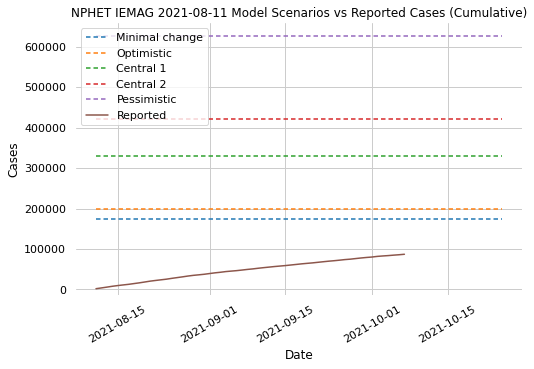

In [10]:
plot_cases(plot_scenarios=['Minimal change', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           plot_scenario='all')

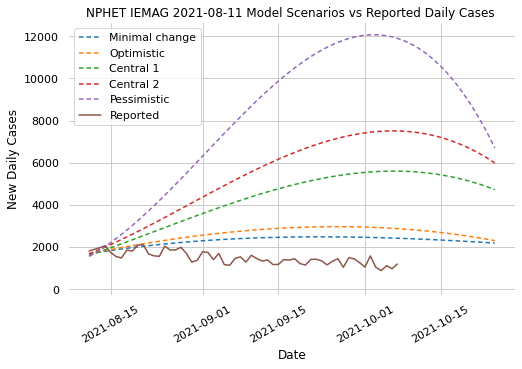

In [11]:
plot_daily_cases(plot_scenarios=['Minimal change', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           #legend_loc='upper right',
           plot_scenario='all')

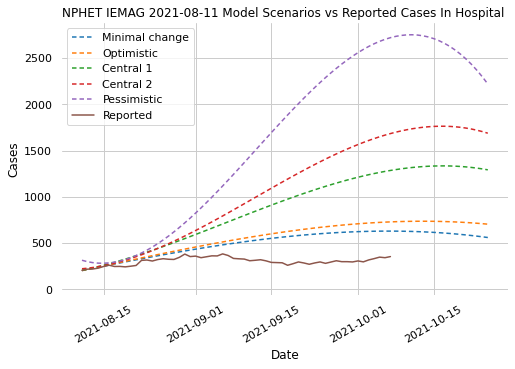

In [12]:
plot_daily_hospital_cases(plot_scenarios=['Minimal change', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           #legend_loc='upper right',
           plot_scenario='all')

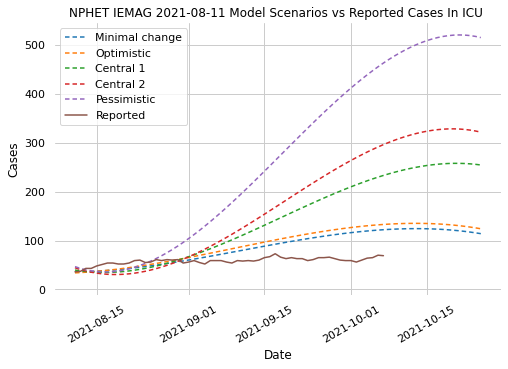

In [13]:
plot_daily_icu_cases(plot_scenarios=['Minimal change', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           #legend_loc='upper right',
           plot_scenario='all')

In [14]:
#plot_hospital_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
#                    model_title='Model', 
#                    legend_loc='upper right',
#                    plot_scenario='all')

In [15]:
#plot_icu_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
#               model_title='Model', 
#               legend_loc='upper right',
#               plot_scenario='all')

In [16]:
#plot_deaths(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
#            model_title='Model', 
#            legend_loc='upper right',
#            plot_scenario='all')

In [17]:
#plot_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
#           model_title='Optimistic-AV',
#           plot_scenario='optimisticav')

In [18]:
#plot_hospital_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
#                    model_title='Optimistic-AV',
#                    plot_scenario='optimisticav')

In [19]:
#plot_icu_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
#               model_title='Optimistic-AV',
#               plot_scenario='optimisticav')

In [20]:
#plot_deaths(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
#            model_title='Optimistic-AV',
#            plot_scenario='optimisticav')

In [21]:
#plot_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#           model_title='Central 1',
#           filename='./figures/nphet20210709_central1_scenarios_vs_reported_cases.png')

In [22]:
#plot_hospital_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#                    model_title='Central 1',
#                    filename='./figures/nphet20210709_central1_scenarios_vs_reported_hospital_cases.png')

In [23]:
#plot_icu_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#               model_title='Central 1',
#               filename='./figures/nphet20210709_central1_scenarios_vs_reported_icu_cases.png')

In [24]:
#plot_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#           model_title='Central 2',
#           filename='./figures/nphet20210709_central2_scenarios_vs_reported_cases.png')

In [25]:
#plot_hospital_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#                    model_title='Central 2',
#                    filename='./figures/nphet20210709_central2_scenarios_vs_reported_hospital_cases.png')

In [26]:
#plot_icu_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#               model_title='Central 2',
#               filename='./figures/nphet20210709_central2_scenarios_vs_reported_icu_cases.png')

In [27]:
#plot_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#           model_title='Pessimistic',
#           filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_cases.png')

In [28]:
#plot_hospital_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#                    model_title='Pessimistic',
#                    filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_hospital_cases.png')

In [29]:
#plot_icu_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#               model_title='Pessimistic',
#               filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_icu_cases.png')

### Generate current cases/hospitalisation/ICU summaries

In [30]:
def generate_summary(reported_column, scenario_cases, title):
    columndf = reporteddf[['Date', reported_column]].dropna()
    num_reported_days = len(columndf)
    scenario_length = len(scenario_dates)
    cases_current_row = columndf.iloc[-1]
    cases_current = int(cases_current_row[reported_column])
    cases_previous = int(columndf.iloc[-2][reported_column])
    new_cases = cases_current - cases_previous
    scenario_status = {}
    print(f"""NPHET IEMAG 2021-08-11 Model Scenarios vs Reported {title}

({datetime.strftime(cases_current_row.Date, "%A %Y-%m-%d")})

- Reported Total: {cases_current} (+{new_cases})
- % Scenario Duration ({len(scenario_dates)} days): {num_reported_days*100/scenario_length:.1f}%""")

    for scenario in ['Optimistic', 'Central 1', 'Central 2', 'Pessimistic']:
        mean_cases = getattr(scenarios[scenario], scenario_cases)
        cases_current_perc = cases_current*100/mean_cases
        scenario_status[scenario] = {
            'cases_current_perc': cases_current_perc,
            'mean_daily_required_cases': (mean_cases - cases_current)/(scenario_length - num_reported_days)
        }
        print(f'- % {scenario} Scenario Total: {cases_current_perc:.1f}% (+{new_cases*100/mean_cases:.1f}%)')
    return scenario_status

In [31]:
cases_status = generate_summary('Cases', 'mean_cases', 'Cases')

NPHET IEMAG 2021-08-11 Model Scenarios vs Reported Cases

(Thursday 2021-10-07)

- Reported Total: 86970 (+1207)
- % Scenario Duration (76 days): 76.3%
- % Optimistic Scenario Total: 43.8% (+0.6%)
- % Central 1 Scenario Total: 26.4% (+0.4%)
- % Central 2 Scenario Total: 20.6% (+0.3%)
- % Pessimistic Scenario Total: 13.9% (+0.2%)


In [32]:
#hosp_status = generate_summary('HospitalCases', 'mean_hospital_cases', 'New HOSPITAL Cases')

In [33]:
#icu_status = generate_summary('IcuCases', 'mean_icu_cases', 'New ICU Cases')

In [34]:
#death_status = generate_summary('Deaths', 'mean_deaths', 'Deaths')

In [35]:
print(f"""As of {datetime.strftime(reporteddf.iloc[-1].Date, "%Y-%m-%d")}, the following cases were reported:\n""")

for status_scenario in ['Optimistic', 'Central 1', 'Central 2', 'Pessimistic']:
    print(f"- {cases_status[status_scenario]['cases_current_perc']:.1f}% cases")

print('\nAverage daily cases required until 2021-10-25 to reach projections:\n')

for status_scenario in ['Optimistic', 'Central 1', 'Central 2', 'Pessimistic']:
    print(f"- {status_scenario}: {cases_status[status_scenario]['mean_daily_required_cases']:.0f}")


As of 2021-10-07, the following cases were reported:

- 43.8% cases
- 26.4% cases
- 20.6% cases
- 13.9% cases

Average daily cases required until 2021-10-25 to reach projections:

- Optimistic: 6193
- Central 1: 13470
- Central 2: 18603
- Pessimistic: 30033
